In [1]:
# !pip install tensorflow==2.9.1 tensorflow_datasets==4.6.0 openpyxl
# !pip install wordcloud

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import sys

import os
import re
import numpy as np
import pandas as pd
from time import time
import tensorflow as tf
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

tf.keras.utils.set_random_seed(1234)

print(f"Tensorflow version {tf.__version__}")

# tf.keras.mixed_precision.set_global_policy('mixed_float16')

Tensorflow version 2.9.1


In [3]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print("Running on TPU {}".format(tpu.cluster_spec().as_dict()["worker"]))
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

print(f"REPLICAS: {strategy.num_replicas_in_sync}")

REPLICAS: 1


Hyperparameters

In [4]:
# Maximum sentence length
MAX_LENGTH = 40

# Maximum number of samples to preprocess
MAX_SAMPLES = 50000

# For tf.data.Dataset
BATCH_SIZE = 64 * strategy.num_replicas_in_sync
BUFFER_SIZE = 20000

# For Transformer
NUM_LAYERS = 4
D_MODEL = 512
NUM_HEADS = 4
UNITS = 512
DROPOUT = 0.2

EPOCHS = 300

Prepare Dataset

In [5]:
dataset = pd.read_excel('output.xlsx')
dataset.head()

,Question,Answer
0,Who was Richard Wyckoff?,Richard Demille Wyckoff (1873–1934) was a stoc...
1,What was Wyckoff's early career like?,Wyckoff's career on Wall Street started early;...
2,What did Wyckoff learn as a broker?,"As a broker, Wyckoff was able to observe the a..."
3,How did Wyckoff feel about retail investors?,Wyckoff saw many retail investors lose money b...
4,What did Wyckoff do to educate investors?,"Wyckoff was an author, editor, and educator. H..."


In [6]:
# Updated preprocessing function to remove ",", ".", and "?"
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()
    # sentence = re.sub(r"([?,.])", r"", sentence)
    # sentence = re.sub(r"([!.])", r" \1 ", sentence)
    # sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Z0-9?.,\s]", "", sentence)
    sentence = re.sub(r"([!.])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    # removing contractions
    sentence = re.sub(r"i'm", "i am", sentence)
    sentence = re.sub(r"he's", "he is", sentence)
    sentence = re.sub(r"she's", "she is", sentence)
    sentence = re.sub(r"it's", "it is", sentence)
    sentence = re.sub(r"that's", "that is", sentence)
    sentence = re.sub(r"what's", "what is", sentence)
    sentence = re.sub(r"where's", "where is", sentence)
    sentence = re.sub(r"how's", "how is", sentence)
    sentence = re.sub(r"\'ll", " will", sentence)
    sentence = re.sub(r"\'ve", " have", sentence)
    sentence = re.sub(r"\'re", " are", sentence)
    sentence = re.sub(r"\'d", " would", sentence)
    sentence = re.sub(r"won't", "will not", sentence)
    sentence = re.sub(r"can't", "cannot", sentence)
    sentence = re.sub(r"n't", " not", sentence)
    sentence = re.sub(r"n'", "ng", sentence)
    sentence = re.sub(r"'bout", "about", sentence)
    # replacing everything with space except (a-z, A-Z, "!")
    # sentence = re.sub(r"[^a-zA-Z!]+", " ", sentence)
    sentence = sentence.strip()
    return sentence

# Re-applying preprocessing to the Excel data without ",", ".", "?"
dataset['Question'] = dataset['Question'].apply(preprocess_sentence)
dataset['Answer'] = dataset['Answer'].apply(preprocess_sentence)

# Display the updated dataset
print(dataset)


                                              Question  \
0                             who was richard wyckoff?   
1                 what was wyckoffs early career like?   
2                  what did wyckoff learn as a broker?   
3         how did wyckoff feel about retail investors?   
4            what did wyckoff do to educate investors?   
..                                                 ...   
271          what defines successful range completion?   
272       how do you identify valid watershed moments?   
273  what are the key characteristics of successful...   
274       how do you identify valid reversal patterns?   
275        what defines successful technical position?   

                                                Answer  
0    richard demille wyckoff 18731934 was a stock m...  
1    wyckoffs career on wall street started early h...  
2    as a broker, wyckoff was able to observe the a...  
3    wyckoff saw many retail investors lose money b...  
4    wyckoff was a

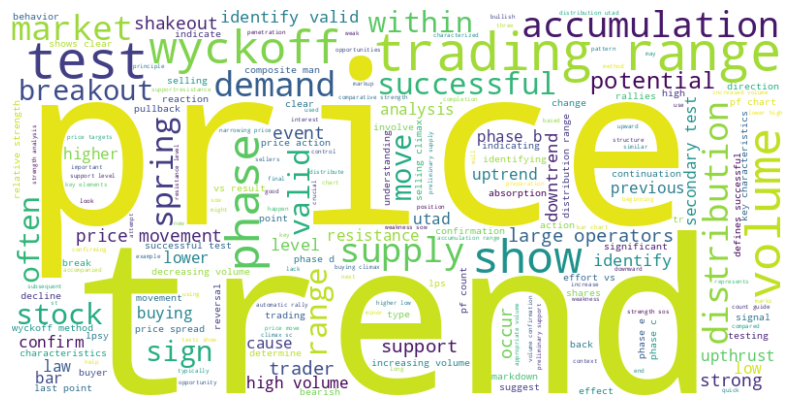

In [7]:
# Combine all text data for the word cloud
text_data = ' '.join(dataset['Question'].tolist() + dataset['Answer'].tolist())

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_data)

# Plot the word cloud
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [8]:
def load_conversations(path_to_excel, max_samples=MAX_SAMPLES):
    # Preprocess the data
    dataset['Question'] = dataset['Question'].apply(preprocess_sentence)
    dataset['Answer'] = dataset['Answer'].apply(preprocess_sentence)

    inputs = dataset['Question'].tolist()
    outputs = dataset['Answer'].tolist()

    # Limit to MAX_SAMPLES
    inputs = inputs[:max_samples]
    outputs = outputs[:max_samples]

    return inputs, outputs

# Load the data
questions, answers = load_conversations(dataset)

# Example output
print(f"Sample Question: {questions[0]}")
print(f"Sample Answer: {answers[0]}")

Sample Question: who was richard wyckoff?
Sample Answer: richard demille wyckoff 18731934 was a stock market pioneer in the early 20th century who developed a technical approach to studying the stock market .


In [9]:
# Build tokenizer using tfds for both questions and answers
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    dataset['Question'].tolist() + dataset['Answer'].tolist(), target_vocab_size=2**13
)

# Define start and end token to indicate the start and end of a sentence
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

# Vocabulary size plus start and end token
VOCAB_SIZE = tokenizer.vocab_size + 2

# Select a sample question for demonstration
sample_question = dataset['Question'].iloc[20]

# Tokenize the sample question
tokenized_sample_question = tokenizer.encode(sample_question)

# Print original sentence and tokenized version
print(f"Original sample question: {sample_question}")
print(f"Tokenized sample question: {tokenized_sample_question}")

# Optional: Decode the tokenized sentence back to text
decoded_sentence = tokenizer.decode(tokenized_sample_question)
print(f"Decoded sample question: {decoded_sentence}")

Original sample question: what is markup?
Tokenized sample question: [12, 8, 416, 1605]
Decoded sample question: what is markup?


In [10]:
# Tokenize, filter, and pad sentences function
def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []

    for (sentence1, sentence2) in zip(inputs, outputs):
        # Tokenize sentence and add start and end tokens
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

        # Check if tokenized sentences are within the max length
        if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
            tokenized_inputs.append(sentence1)
            tokenized_outputs.append(sentence2)

    # Pad tokenized sentences
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_inputs, maxlen=MAX_LENGTH, padding="post"
    )
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_outputs, maxlen=MAX_LENGTH, padding="post"
    )

    return tokenized_inputs, tokenized_outputs

# Call the function
tokenized_questions, tokenized_answers = tokenize_and_filter(questions, answers)

print(f"Number of tokenized questions: {len(tokenized_questions)}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Steps per epoch: {len(tokenized_questions) // BATCH_SIZE}")


Number of tokenized questions: 177
Batch size: 64
Steps per epoch: 2


In [11]:
# Print a sample to verify
print(f"Sample tokenized question: {questions[0]}")
print(f"Sample tokenized question: {tokenized_questions[0]}")
print(f"Sample tokenized answer: {answers[0]}")
print(f"Sample tokenized answer: {tokenized_answers[0]}")

Sample tokenized question: who was richard wyckoff?
Sample tokenized question: [1798  219  272  305  672 1605 1799    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]
Sample tokenized answer: richard demille wyckoff 18731934 was a stock market pioneer in the early 20th century who developed a technical approach to studying the stock market .
Sample tokenized answer: [1798  305 1376   28  949  272    3   84   60  781    9    1  516 1538
 1435  219 1369    3  384  665   11  388    1   84  112    5 1799    0
    0    0    0    0    0    0    0    0    0    0    0    0]


In [12]:
print(f"Vocab size: {VOCAB_SIZE}")
print(f"Number of samples: {len(questions)}")

Vocab size: 1800
Number of samples: 276


Create tf.data.Dataset

In [13]:
# Split the data into 80% training and 20% validation
train_size = int(0.8 * len(tokenized_questions))
val_questions = tokenized_questions[train_size:]
val_answers = tokenized_answers[train_size:]

train_dataset = tf.data.Dataset.from_tensor_slices(
    ({"inputs": tokenized_questions[:train_size], "dec_inputs": tokenized_answers[:train_size, :-1]},
     {"outputs": tokenized_answers[:train_size, 1:]})
)

val_dataset = tf.data.Dataset.from_tensor_slices(
    ({"inputs": val_questions, "dec_inputs": val_answers[:, :-1]},
     {"outputs": val_answers[:, 1:]})
)

# Prepare datasets with batching, shuffling, and prefetching
train_dataset = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.cache().batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


In [14]:
# decoder inputs use the previous target as input
# remove START_TOKEN from targets
dataset = tf.data.Dataset.from_tensor_slices(
    (
        {"inputs": tokenized_questions, "dec_inputs": tokenized_answers[:, :-1]},
        {"outputs": tokenized_answers[:, 1:]},
    )
)

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.AUTOTUNE)

print(dataset)

<PrefetchDataset element_spec=({'inputs': TensorSpec(shape=(None, 40), dtype=tf.int32, name=None), 'dec_inputs': TensorSpec(shape=(None, 39), dtype=tf.int32, name=None)}, {'outputs': TensorSpec(shape=(None, 39), dtype=tf.int32, name=None)})>


## Attention

### Scaled dot product Attention

The scaled dot-product attention function used by the transformer takes three inputs: Q (query), K (key), V (value). The equation used to calculate the attention weights is:

$$\normalsize{Attention(Q, K, V) = softmax_k(\frac{QK^T}{\sqrt{d_k}}) V} $$

In [15]:
def scaled_dot_product_attention(query, key, value, mask):
    """Calculate the attention weights."""
    matmul_qk = tf.matmul(query, key, transpose_b=True)

    # scale matmul_qk
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)

    # add the mask to zero out padding tokens
    if mask is not None:
        logits += mask * -1e9

    # softmax is normalized on the last axis (seq_len_k)
    attention_weights = tf.nn.softmax(logits, axis=-1)

    output = tf.matmul(attention_weights, value)

    return output

### Multi-head attention

Multi-head attention consists of four parts:
* Linear layers and split into heads.
* Scaled dot-product attention.
* Concatenation of heads.
* Final linear layer.

In [16]:
class MultiHeadAttentionLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, **kwargs):
        assert d_model % num_heads == 0
        super(MultiHeadAttentionLayer, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.d_model = d_model

        self.depth = d_model // self.num_heads

        # self.query_dense = tf.keras.layers.Dense(units=d_model)
        # self.key_dense = tf.keras.layers.Dense(units=d_model)
        # self.value_dense = tf.keras.layers.Dense(units=d_model)
        self.query_dense = tf.keras.layers.Dense(
            units=d_model, kernel_regularizer=tf.keras.regularizers.l2(0.01)
        )
        self.key_dense = tf.keras.layers.Dense(
            units=d_model, kernel_regularizer=tf.keras.regularizers.l2(0.01)
        )
        self.value_dense = tf.keras.layers.Dense(
            units=d_model, kernel_regularizer=tf.keras.regularizers.l2(0.01)
        )
        self.dense = tf.keras.layers.Dense(
            units=d_model, kernel_regularizer=tf.keras.regularizers.l2(0.01)
        )

        self.dense = tf.keras.layers.Dense(units=d_model)

    def get_config(self):
        config = super(MultiHeadAttentionLayer, self).get_config()
        config.update(
            {
                "num_heads": self.num_heads,
                "d_model": self.d_model,
            }
        )
        return config

    def split_heads(self, inputs, batch_size):
        inputs = tf.keras.layers.Lambda(
            lambda inputs: tf.reshape(
                inputs, shape=(batch_size, -1, self.num_heads, self.depth)
            )
        )(inputs)
        return tf.keras.layers.Lambda(
            lambda inputs: tf.transpose(inputs, perm=[0, 2, 1, 3])
        )(inputs)

    def call(self, inputs):
        query, key, value, mask = (
            inputs["query"],
            inputs["key"],
            inputs["value"],
            inputs["mask"],
        )
        batch_size = tf.shape(query)[0]

        # linear layers
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # split heads
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # scaled dot-product attention
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)
        scaled_attention = tf.keras.layers.Lambda(
            lambda scaled_attention: tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        )(scaled_attention)

        # concatenation of heads
        concat_attention = tf.keras.layers.Lambda(
            lambda scaled_attention: tf.reshape(
                scaled_attention, (batch_size, -1, self.d_model)
            )
        )(scaled_attention)

        # final linear layer
        outputs = self.dense(concat_attention)

        return outputs

## Transformer

`create_padding_mask` and `create_look_ahead` are helper functions to creating masks to mask out padded tokens, we are going to use these helper functions as `tf.keras.layers.Lambda` layers.

Mask all the pad tokens (value `0`) in the batch to ensure the model does not treat padding as input.

In [17]:
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    # (batch_size, 1, 1, sequence length)
    return mask[:, tf.newaxis, tf.newaxis, :]

In [18]:
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)

### Positional encoding

Since this model doesn't contain any recurrence or convolution, positional encoding is added to give the model some information about the relative position of the words in the sentence.

In [19]:
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model, **kwargs):
        super(PositionalEncoding, self).__init__(**kwargs)
        self.position = position
        self.d_model = d_model
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_config(self):
        config = super(PositionalEncoding, self).get_config()
        config.update(
            {
                "position": self.position,
                "d_model": self.d_model,
            }
        )
        return config

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model,
        )
        # apply sin to even index in the array
        sines = tf.math.sin(angle_rads[:, 0::2])
        # apply cos to odd index in the array
        cosines = tf.math.cos(angle_rads[:, 1::2])

        pos_encoding = tf.concat([sines, cosines], axis=-1)
        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, : tf.shape(inputs)[1], :]

### Encoder Layer

Each encoder layer consists of sublayers:

1. Multi-head attention (with padding mask)
2. 2 dense layers followed by dropout

Each of these sublayers has a residual connection around it followed by a layer normalization. Residual connections help in avoiding the vanishing gradient problem in deep networks.

The output of each sublayer is `LayerNorm(x + Sublayer(x))`. The normalization is done on the `d_model` (last) axis.

In [20]:
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    attention = MultiHeadAttentionLayer(d_model, num_heads, name="attention")(
        {"query": inputs, "key": inputs, "value": inputs, "mask": padding_mask}
    )
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    add_attention = tf.keras.layers.add([inputs, attention])
    attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)(add_attention)

    outputs = tf.keras.layers.Dense(units=units, activation="relu", kernel_regularizer=tf.keras.regularizers.l2(0.01))(attention) #changed
    outputs = tf.keras.layers.Dense(units=d_model, kernel_regularizer=tf.keras.regularizers.l2(0.01))(outputs) #changed
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    add_attention = tf.keras.layers.add([attention, outputs])
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(add_attention)

    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

### Encoder

The Encoder consists of:
1.   Input Embedding
2.   Positional Encoding
3.   `num_layers` encoder layers

The input is put through an embedding which is summed with the positional encoding. The output of this summation is the input to the encoder layers. The output of the encoder is the input to the decoder.

In [21]:
def encoder(vocab_size, num_layers, units, d_model, num_heads, dropout, name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.keras.layers.Lambda(
        lambda d_model: tf.math.sqrt(tf.cast(d_model, tf.float32))
    )(d_model)
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = encoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name="encoder_layer_{}".format(i),
        )([outputs, padding_mask])

    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

### Decoder Layer

Each decoder layer consists of sublayers:

1.   Masked multi-head attention (with look ahead mask and padding mask)
2.   Multi-head attention (with padding mask). `value` and `key` receive the *encoder output* as inputs. `query` receives the *output from the masked multi-head attention sublayer.*
3.   2 dense layers followed by dropout

Each of these sublayers has a residual connection around it followed by a layer normalization. The output of each sublayer is `LayerNorm(x + Sublayer(x))`. The normalization is done on the `d_model` (last) axis.

As `query` receives the output from decoder's first attention block, and `key` receives the encoder output, the attention weights represent the importance given to the decoder's input based on the encoder's output. In other words, the decoder predicts the next word by looking at the encoder output and self-attending to its own output. See the demonstration above in the scaled dot product attention section.

In [22]:
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    attention1 = MultiHeadAttentionLayer(d_model, num_heads, name="attention_1")(
        inputs={
            "query": inputs,
            "key": inputs,
            "value": inputs,
            "mask": look_ahead_mask,
        }
    )
    add_attention = tf.keras.layers.add([attention1, inputs])
    attention1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(add_attention)

    attention2 = MultiHeadAttentionLayer(d_model, num_heads, name="attention_2")(
        inputs={
            "query": attention1,
            "key": enc_outputs,
            "value": enc_outputs,
            "mask": padding_mask,
        }
    )
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    add_attention = tf.keras.layers.add([attention2, attention1])
    attention2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(add_attention)

    outputs = tf.keras.layers.Dense(units=units, activation="relu")(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    add_attention = tf.keras.layers.add([outputs, attention2])
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(add_attention)

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name,
    )

### Decoder

The Decoder consists of:
1.   Output Embedding
2.   Positional Encoding
3.   N decoder layers

The target is put through an embedding which is summed with the positional encoding. The output of this summation is the input to the decoder layers. The output of the decoder is the input to the final linear layer.

In [23]:
def decoder(vocab_size, num_layers, units, d_model, num_heads, dropout, name="decoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.keras.layers.Lambda(
        lambda d_model: tf.math.sqrt(tf.cast(d_model, tf.float32))
    )(d_model)
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = decoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name="decoder_layer_{}".format(i),
        )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name,
    )

### Transformer

Transformer consists of the encoder, decoder and a final linear layer. The output of the decoder is the input to the linear layer and its output is returned.

In [24]:
def transformer(
    vocab_size, num_layers, units, d_model, num_heads, dropout, name="transformer"
):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

    enc_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None), name="enc_padding_mask"
    )(inputs)
    # mask the future tokens for decoder inputs at the 1st attention block
    look_ahead_mask = tf.keras.layers.Lambda(
        create_look_ahead_mask, output_shape=(1, None, None), name="look_ahead_mask"
    )(dec_inputs)
    # mask the encoder outputs for the 2nd attention block
    dec_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None), name="dec_padding_mask"
    )(inputs)

    enc_outputs = encoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[inputs, enc_padding_mask])

    dec_outputs = decoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

## Train model

### Loss function

Since the target sequences are padded, it is important to apply a padding mask when calculating the loss.

In [25]:
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))

    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction="none"
    )(y_true, y_pred)

    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)

    return tf.reduce_mean(loss)

### Custom learning rate


$$\normalsize{lrate = d_{model}^{-0.5} * min(step{\_}num^{-0.5}, step{\_}num * warmup{\_}steps^{-1.5})}$$

In [26]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = tf.constant(d_model, dtype=tf.float32)
        self.warmup_steps = warmup_steps

    def get_config(self):
        return {"d_model": self.d_model, "warmup_steps": self.warmup_steps}

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.multiply(
            tf.math.rsqrt(self.d_model), tf.math.minimum(arg1, arg2)
        )

### Initialize and compile model

Initialize and compile model with our predefined custom learning rate and Adam optimizer under the strategy scope.

In [27]:
# clear backend
tf.keras.backend.clear_session()

learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9, clipnorm=0.5
)


def accuracy(y_true, y_pred):
    # ensure labels have shape (batch_size, MAX_LENGTH - 1)
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

# Define early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True
)


# initialize and compile model within strategy scope
with strategy.scope():
    model = transformer(
        vocab_size=VOCAB_SIZE,
        num_layers=NUM_LAYERS,
        units=UNITS,
        d_model=D_MODEL,
        num_heads=NUM_HEADS,
        dropout=DROPOUT,
    )

    model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, None)]       0           []                               
                                                                                                  
 dec_inputs (InputLayer)        [(None, None)]       0           []                               
                                                                                                  
 enc_padding_mask (Lambda)      (None, 1, 1, None)   0           ['inputs[0][0]']                 
                                                                                                  
 encoder (Functional)           (None, None, 512)    7233536     ['inputs[0][0]',                 
                                                                  'enc_padding_mask[0][0

### Fit model

Train our transformer by simply calling `model.fit()`

In [28]:
# model.fit(dataset, epochs=EPOCHS)
history = model.fit(train_dataset, epochs=EPOCHS, callbacks=[early_stopping], validation_data=val_dataset)

Epoch 1/300
3/3 [==============================] - 41s 8s/step - loss: 231.4573 - accuracy: 3.6370e-04 - val_loss: 230.1625 - val_accuracy: 0.0000e+00
Epoch 2/300
3/3 [==============================] - 21s 6s/step - loss: 231.4460 - accuracy: 5.4555e-04 - val_loss: 230.1343 - val_accuracy: 0.0000e+00
Epoch 3/300
3/3 [==============================] - 20s 6s/step - loss: 231.4169 - accuracy: 3.6370e-04 - val_loss: 230.0853 - val_accuracy: 0.0000e+00
Epoch 4/300
3/3 [==============================] - 19s 6s/step - loss: 231.3719 - accuracy: 3.6370e-04 - val_loss: 230.0155 - val_accuracy: 0.0000e+00
Epoch 5/300
3/3 [==============================] - 19s 6s/step - loss: 231.2973 - accuracy: 3.6370e-04 - val_loss: 229.9255 - val_accuracy: 0.0000e+00
Epoch 6/300
3/3 [==============================] - 20s 6s/step - loss: 231.2163 - accuracy: 3.6370e-04 - val_loss: 229.8160 - val_accuracy: 0.0000e+00
Epoch 7/300
3/3 [==============================] - 19s 6s/step - loss: 231.1075 - accuracy: 0.

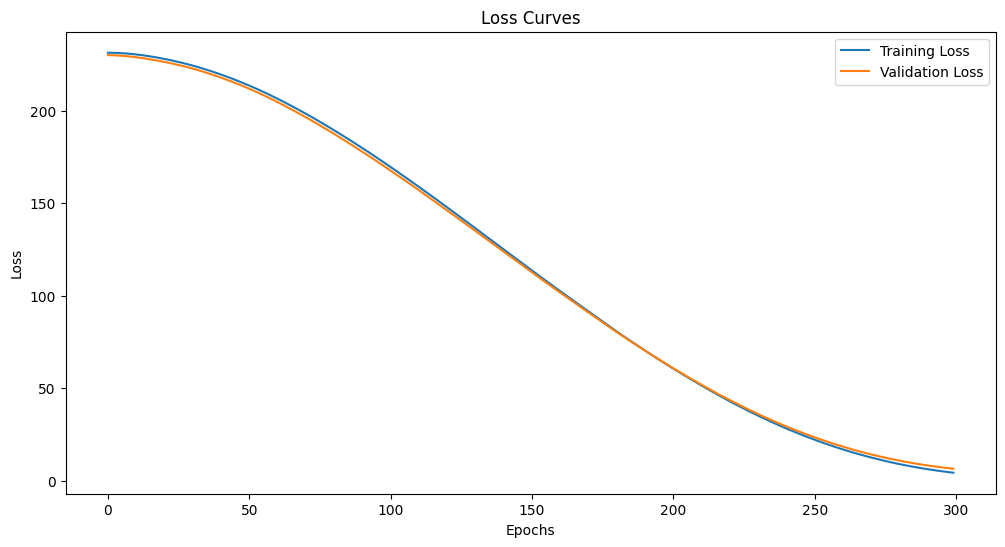

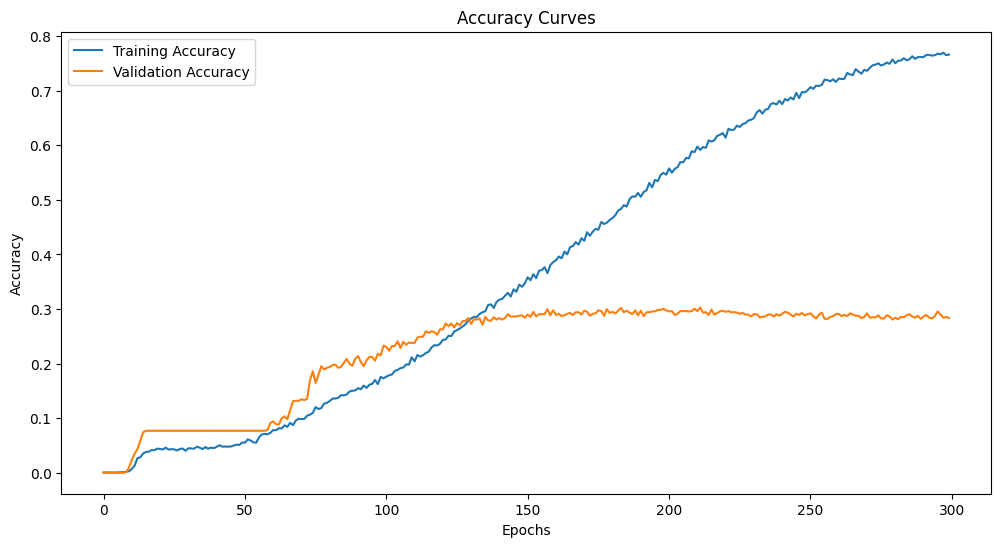

In [29]:
# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curves')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


### Save and load model

## Evaluate and predict

The following steps are used for evaluation:

* Apply the same preprocessing method we used to create our dataset for the input sentence.
* Tokenize the input sentence and add `START_TOKEN` and `END_TOKEN`.
* Calculate the padding masks and the look ahead masks.
* The decoder then outputs the predictions by looking at the encoder output and its own output.
* Select the last word and calculate the argmax of that.
* Concatentate the predicted word to the decoder input as pass it to the decoder.
* In this approach, the decoder predicts the next word based on the previous words it predicted.

Note: The model used here has less capacity and trained on a subset of the full dataset, hence its performance can be further improved.

In [30]:
def evaluate(sentence):
    sentence = preprocess_sentence(sentence)

    sentence = tf.expand_dims(
        START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0
    )

    output = tf.expand_dims(START_TOKEN, 0)

    for i in range(MAX_LENGTH):
        predictions = model(inputs=[sentence, output], training=False)

        # select the last word from the seq_len dimension
        predictions = predictions[:, -1:, :]
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # return the result if the predicted_id is equal to the end token
        if tf.equal(predicted_id, END_TOKEN[0]):
            break

        # concatenated the predicted_id to the output which is given to the decoder
        # as its input.
        output = tf.concat([output, predicted_id], axis=-1)

    return tf.squeeze(output, axis=0)


def predict(sentence):
    prediction = evaluate(sentence)
    predicted_sentence = tokenizer.decode(
        [i for i in prediction if i < tokenizer.vocab_size]
    )
    return predicted_sentence

Testing

In [31]:
predict("who was richard wyckoff")

'richard demille wyckoff 18731934 was a stock market pioneer in the early 20th century who developed a technical approach to studying the stock market .'

In [32]:
predict("what is the composite man")

'the composite man is a heuristic device used to understand price movements . wyckoff advised traders to study the markets as if a single entity, the composite man, was behind all the price fluctuations .'

In [33]:
def beam_search(sentence, beam_width=3):
    sentence = preprocess_sentence(sentence)
    sentence = tf.expand_dims(START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

    sequences = [[list(START_TOKEN), 0.0]]

    for _ in range(MAX_LENGTH):
        all_candidates = []
        for seq, score in sequences:
            output = tf.expand_dims(seq, axis=0)
            predictions = model(inputs=[sentence, output], training=False)
            predictions = predictions[:, -1, :]
            top_k = tf.nn.top_k(predictions, k=beam_width)

            for i in range(beam_width):
                candidate = seq + [int(top_k.indices[0][i])]
                candidate_score = score + float(tf.math.log(top_k.values[0][i]))
                all_candidates.append([candidate, candidate_score])

        # Sort all candidates by score and keep the top beam_width sequences
        sequences = sorted(all_candidates, key=lambda x: x[1], reverse=True)[:beam_width]

        if sequences[0][0][-1] == END_TOKEN[0]:
            break

    best_sequence = sequences[0][0]
    return tokenizer.decode([i for i in best_sequence if i < tokenizer.vocab_size])

# Example usage
print(beam_search("who was richard wyckoff?"))


richard demille wyckoff 18731934 was a stock market pioneer in the early 20th century who developed a technical approach to studying the market .


In [34]:
print(beam_search("what is the composite man?"))

the composite man is a heuristic device used to understand price movements . wyckoff advised traders to study the markets as if a single entity, the composite man .


In [35]:
predict("What is markup?")

'markup is a sustained upward price movement driven by increasing demand from both large operators and the public who are drawn in by rising prices .'

In [36]:
print(beam_search("What is markup?"))

markup is a sustained upward price movement driven by increasing demand from both large operators and the public who are drawn in by rising prices .
